In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
import plotly.graph_objects as go
from PIL import Image
# from google.colab import files #Librería para cargar ficheros directamente en Colab
%matplotlib inline

In [3]:
df = pd.read_csv('./data_mask.csv')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [5]:
df.head(50)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
5,TCGA_CS_5395_19981004,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...,0
6,TCGA_CS_5395_19981004,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...,0
7,TCGA_CS_5395_19981004,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1_...,0
8,TCGA_CS_5395_19981004,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_...,0
9,TCGA_CS_5395_19981004,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1_...,0


In [6]:
df['mask'].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

In [7]:
df.duplicated().value_counts()

False    3929
Name: count, dtype: int64

## Mini reto

1. ¿Tenemos un dataset balanceado?
2. ¿Cuantas muestras están marcadas como 'paciente sano'?


1. El dataset no esta balanceado con un 65.08% de pacientes sanos y un 34.98% de pacientes con tumores cerebrales en resumen el dataset no esta balanceado

2. 2556 Son pacientes sanos

In [8]:
counts = df['mask'].value_counts()

# Crear figura de barras
fig = go.Figure(data=go.Bar(x=counts.index, y=counts.values))

# Personalizar diseño y estilo
fig.update_layout(
    title='Conteo de valores en la columna "mask"',
    xaxis=dict(title='Valores'),
    yaxis=dict(title='Conteo'),
    hovermode='x'
)

# Mostrar figura interactiva
fig.show()

In [9]:
df['mask_path'].head(50)

0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
5     TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...
6     TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...
7     TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1_...
8     TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_...
9     TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1_...
10    TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_1_...
11    TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_1_...
12    TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_1_...
13    TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_1_...
14    TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_1_...
15    TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_1_...
16    TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_1_...
17    TCGA_DU_5872_19950223/TCGA_DU_5872_1995022

In [10]:
df['image_path'].head(50)

0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
5     TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif
6     TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif
7     TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif
8     TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif
9     TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif
10    TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_1.tif
11    TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_1.tif
12    TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_1.tif
13    TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_1.tif
14    TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_1.tif
15    TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_1.tif
16    TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_1.tif
17    TCGA_DU_5872_19950223/TCGA_DU_5872_1995022

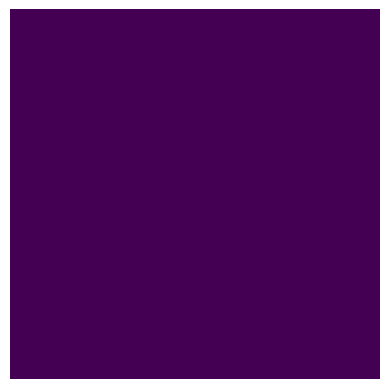

In [11]:
# Ruta de la imagen
ruta_imagen = './TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif'

# Leer la imagen
imagen = plt.imread(ruta_imagen)

# Mostrar la imagen
plt.imshow(imagen)
plt.axis('off')  # Opcional: quitar los ejes
plt.show()

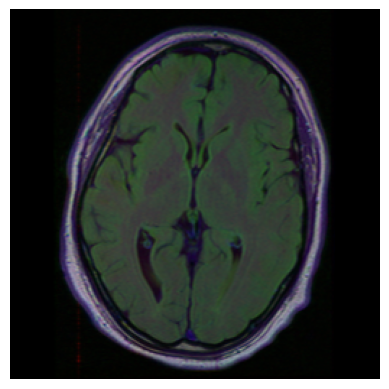

In [12]:
# Ruta de la imagen
ruta_imagen = './TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_10.tif'

# Leer la imagen
imagen = plt.imread(ruta_imagen)

# Mostrar la imagen
plt.imshow(imagen)
plt.axis('off')  # Opcional: quitar los ejes
plt.show()

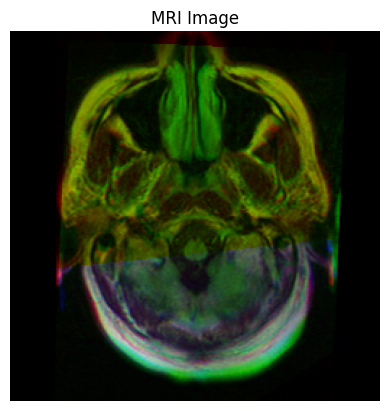

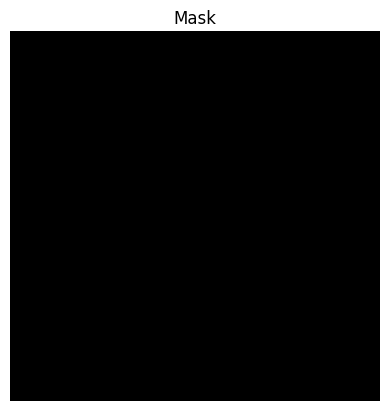

In [13]:
# Supongamos que tienes un dataset de imágenes MRI y máscaras almacenadas en dos listas separadas
mri_images = ['TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif']  # Lista de imágenes MRI
masks = ['TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif']  # Lista de máscaras correspondientes

# Supongamos que quieres visualizar la primera imagen y su máscara correspondiente
mri_image = mri_images[0]
mask = masks[0]

# Cargar la imagen MRI y la máscara
mri = Image.open(mri_image)
mask = Image.open(mask)

# Convertir las imágenes a arrays numpy
mri_array = np.array(mri)
mask_array = np.array(mask)

# Visualización de la imagen MRI
plt.figure()
plt.imshow(mri_array, cmap='gray')
plt.title('MRI Image')
plt.axis('off')
plt.show()

# Visualización de la máscara
plt.figure()
plt.imshow(mask_array, cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()

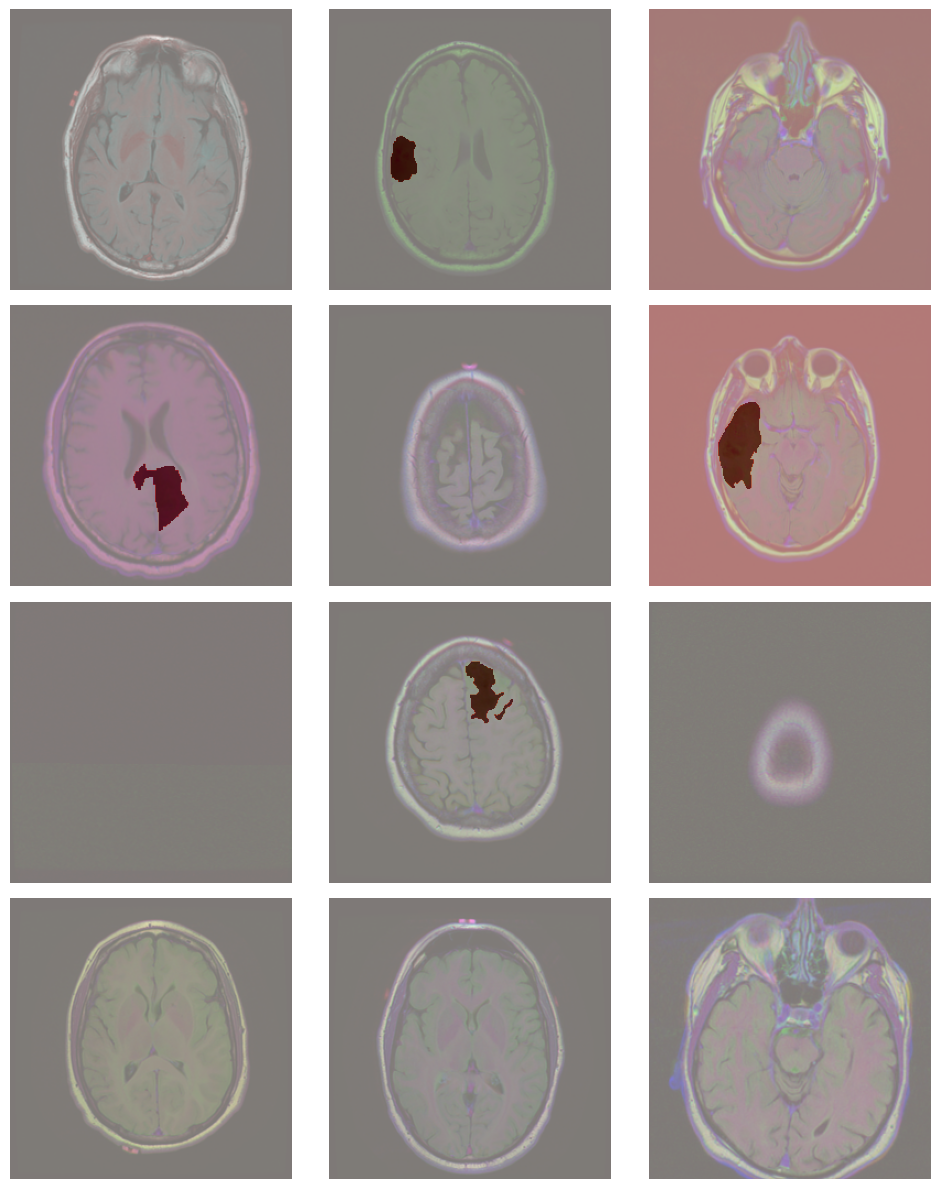

In [21]:
# Seleccionar aleatoriamente 12 muestras del dataset
muestras_aleatorias = df.sample(n=12)

# Crear una figura con subplots de 4 filas y 3 columnas
fig, axs = plt.subplots(4, 3, figsize=(10, 12))

# Iterar sobre los subplots y mostrar las imágenes y máscaras correspondientes
for i, ax in enumerate(axs.flat):
    muestra = muestras_aleatorias.iloc[i]
    
    # Leer la imagen y la máscara correspondiente
    imagen = plt.imread(muestra['image_path'])
    mascara = plt.imread(muestra['mask_path'])
    
    # Mostrar la imagen de MRI
    ax.imshow(imagen, cmap='gray')
    
    # Mostrar la máscara en rojo (superponiendo la imagen de MRI)
    ax.imshow(mascara, cmap='Reds', alpha=0.5)  
    
    # Desactivar los ejes y el etiquetado
    ax.axis('off')

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

## Mini reto tres

1. ¿Cuál es el rendimiento de ResNet en el conjunto de datos ImageNet?
2. ¿?